In [1]:
# Parameters

frequency = 'day'
resolution = '44i' #44i = 0.5; 22i = 0.25 lat/lon
bias_correction = 'raw' # raw, mbcn-Daymet, or mbcn-gridMET

simulations = ['CanESM2.CanRCM4', 'CanESM2.RCA4']

In [2]:
import intake
import pandas as pd

# need AWS access keys set up in environ to pull zarr files
zarr_urls = {
    'rcp45_prec':f's3://ncar-na-cordex/day/prec.rcp45.{frequency}.NAM-{resolution}.{bias_correction}.zarr',
    'rcp85_prec':f's3://ncar-na-cordex/day/prec.rcp85.{frequency}.NAM-{resolution}.{bias_correction}.zarr',
    'rcp45_temp':f's3://ncar-na-cordex/day/temp.rcp45.{frequency}.NAM-{resolution}.{bias_correction}.zarr',
    'rcp85_temp':f's3://ncar-na-cordex/day/temp.rcp85.{frequency}.NAM-{resolution}.{bias_correction}.zarr'
}

datasets = {}

for key, url in zarr_urls.items():

    zarr_cat = intake.open_zarr(url)
    zarr_source = zarr_cat()
    
    try:
        # Attempt to load the dataset
        dataset = zarr_source.to_dask()
        datasets[key] = dataset
        print(f"Dataset from {url} loaded successfully")

    except Exception as e:
        print(f"Error loading dataset from {url}: {e}")

Dataset from s3://ncar-na-cordex/day/prec.rcp45.day.NAM-44i.raw.zarr loaded successfully
Dataset from s3://ncar-na-cordex/day/prec.rcp85.day.NAM-44i.raw.zarr loaded successfully
Dataset from s3://ncar-na-cordex/day/temp.rcp45.day.NAM-44i.raw.zarr loaded successfully
Dataset from s3://ncar-na-cordex/day/temp.rcp85.day.NAM-44i.raw.zarr loaded successfully


In [3]:
# Get dataset, filter, aggregate with xarray
rcp45_prec_ds = (
    datasets.get('rcp45_prec')
        .sel(
            lat = slice(37,41), 
            lon = slice(-105,-102), 
            member_id = simulations, 
            bnds = 0)
        .drop('time_bnds')
        .mean(dim=['lat', 'lon'])
)

rcp85_prec_ds = (
    datasets.get('rcp85_prec')
        .sel(
            lat = slice(37,41), 
            lon = slice(-105,-102), 
            member_id = simulations, 
            bnds = 0)
        .drop('time_bnds')
        .mean(dim=['lat', 'lon'])
)

rcp45_temp_ds = (
    datasets.get('rcp45_temp')
        .sel(
            lat = slice(37,41), 
            lon = slice(-105,-102), 
            member_id = simulations, 
            bnds = 0)
        .drop('time_bnds')
        .mean(dim=['lat', 'lon'])
)

rcp85_temp_ds = (
    datasets.get('rcp85_temp')
        .sel(
            lat = slice(37,41), 
            lon = slice(-105,-102), 
            member_id = simulations,
              bnds = 0)
        .drop('time_bnds')
        .mean(dim=['lat', 'lon'])
)

ds_dict = {
    'rcp45_prec_ds':rcp45_prec_ds,
    'rcp45_temp_ds':rcp45_temp_ds,
    'rcp85_prec_ds':rcp85_prec_ds,
    'rcp85_temp_ds':rcp85_temp_ds
}

In [4]:
for name, ds in ds_dict.items():
    for id in ds.member_id:
        (ds.sel(member_id = id)
            .drop_vars('member_id')
            .to_dataframe()
            .reset_index()
            .to_parquet(
                f'data/scenarios/{name}_{frequency}_{resolution}_{bias_correction}_{id.values}.parquet'))

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Parquet files for different RCP scenarios
rcp45_prec = pd.read_parquet('data/scenarios/rcp45_prec_ds_day_44i_raw_CanESM2.CanRCM4.parquet')
rcp85_prec = pd.read_parquet('data/scenarios/rcp85_prec_ds_day_44i_raw_CanESM2.CanRCM4.parquet')
rcp45_temp = pd.read_parquet('data/scenarios/rcp45_temp_ds_day_44i_raw_CanESM2.CanRCM4.parquet')
rcp85_temp = pd.read_parquet('data/scenarios/rcp85_temp_ds_day_44i_raw_CanESM2.CanRCM4.parquet')

In [10]:
# Show cleaned data
display(rcp45_prec)
display(rcp85_prec)
display(rcp45_temp)
display(rcp85_temp)

,time,prec
0,2006-01-01 12:00:00,0.119325
1,2006-01-02 12:00:00,7.660387
2,2006-01-03 12:00:00,1.329510
3,2006-01-04 12:00:00,0.000000
4,2006-01-05 12:00:00,0.057530
...,...,...
34693,2100-12-27 12:00:00,0.000042
34694,2100-12-28 12:00:00,0.029922
34695,2100-12-29 12:00:00,0.000167
34696,2100-12-30 12:00:00,0.061470


,time,prec
0,2006-01-01 12:00:00,0.112066
1,2006-01-02 12:00:00,7.698298
2,2006-01-03 12:00:00,1.308521
3,2006-01-04 12:00:00,0.000001
4,2006-01-05 12:00:00,0.073768
...,...,...
34693,2100-12-27 12:00:00,4.506178
34694,2100-12-28 12:00:00,0.434761
34695,2100-12-29 12:00:00,0.151515
34696,2100-12-30 12:00:00,1.358718


,time,temp
0,2006-01-01 12:00:00,-0.508877
1,2006-01-02 12:00:00,-5.345500
2,2006-01-03 12:00:00,-6.925967
3,2006-01-04 12:00:00,-10.128839
4,2006-01-05 12:00:00,-4.190552
...,...,...
34693,2100-12-27 12:00:00,4.441753
34694,2100-12-28 12:00:00,1.819755
34695,2100-12-29 12:00:00,-2.081354
34696,2100-12-30 12:00:00,3.549849


,time,temp
0,2006-01-01 12:00:00,-0.500933
1,2006-01-02 12:00:00,-5.337873
2,2006-01-03 12:00:00,-6.921085
3,2006-01-04 12:00:00,-10.124808
4,2006-01-05 12:00:00,-4.370772
...,...,...
34693,2100-12-27 12:00:00,4.882365
34694,2100-12-28 12:00:00,4.825848
34695,2100-12-29 12:00:00,3.130872
34696,2100-12-30 12:00:00,4.002701


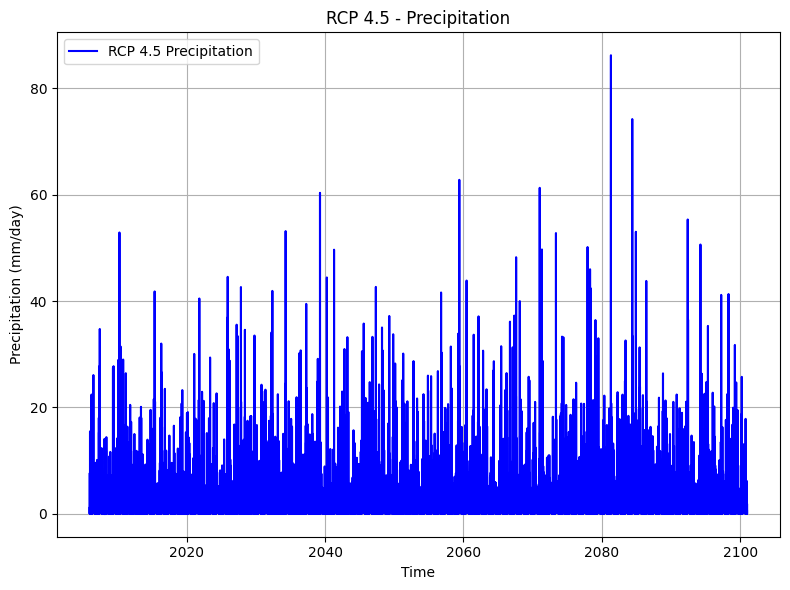

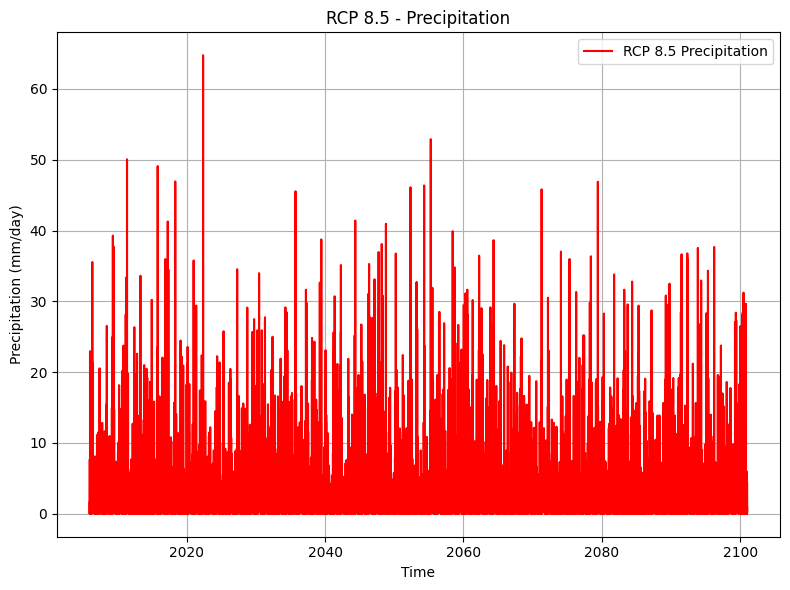

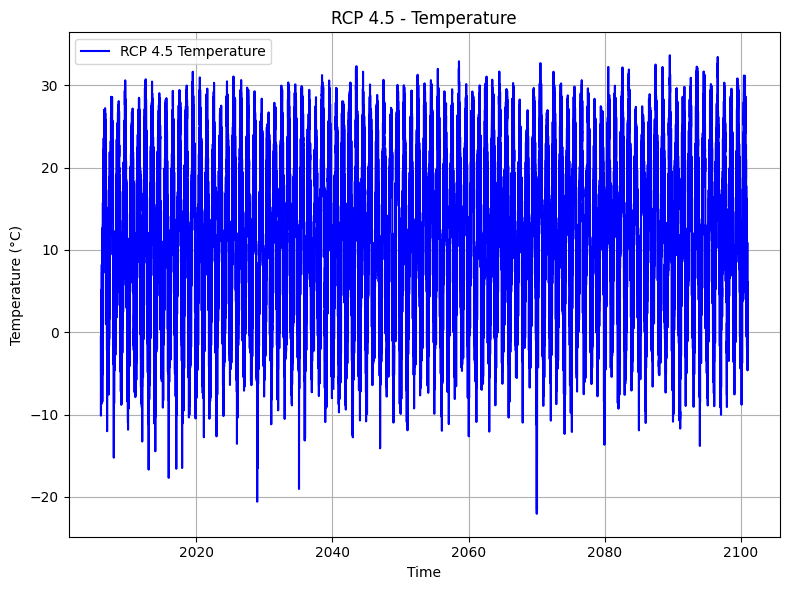

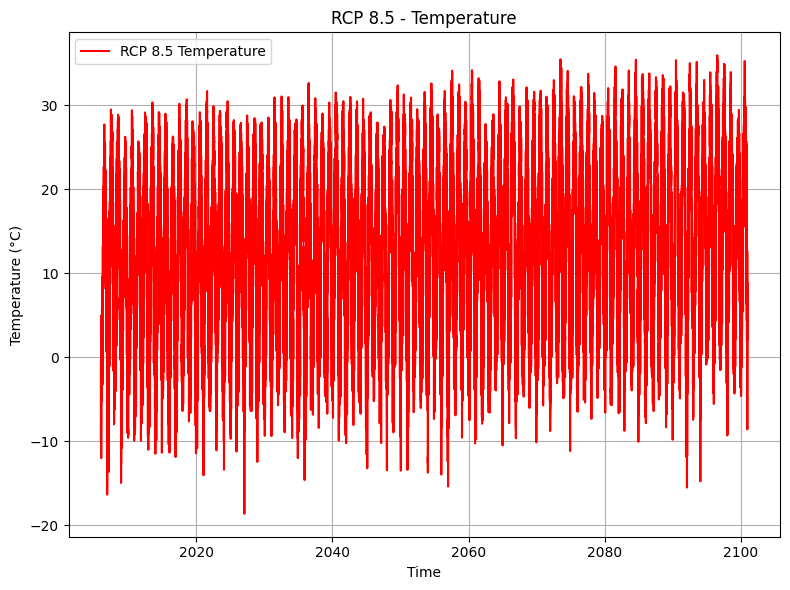

In [12]:
def plot_individual_scenarios(rcp45_prec, rcp85_prec, rcp45_temp, rcp85_temp):
    # Plot RCP 4.5 - Precipitation
    plt.figure(figsize=(8, 6))
    plt.plot(rcp45_prec['time'], rcp45_prec['prec'], label='RCP 4.5 Precipitation', color='blue')
    plt.title('RCP 4.5 - Precipitation')
    plt.ylabel('Precipitation (mm/day)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot RCP 8.5 - Precipitation
    plt.figure(figsize=(8, 6))
    plt.plot(rcp85_prec['time'], rcp85_prec['prec'], label='RCP 8.5 Precipitation', color='red')
    plt.title('RCP 8.5 - Precipitation')
    plt.ylabel('Precipitation (mm/day)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot RCP 4.5 - Temperature
    plt.figure(figsize=(8, 6))
    plt.plot(rcp45_temp['time'], rcp45_temp['temp'], label='RCP 4.5 Temperature', color='blue')
    plt.title('RCP 4.5 - Temperature')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot RCP 8.5 - Temperature
    plt.figure(figsize=(8, 6))
    plt.plot(rcp85_temp['time'], rcp85_temp['temp'], label='RCP 8.5 Temperature', color='red')
    plt.title('RCP 8.5 - Temperature')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to create the four charts
plot_individual_scenarios(rcp45_prec, rcp85_prec, rcp45_temp, rcp85_temp)

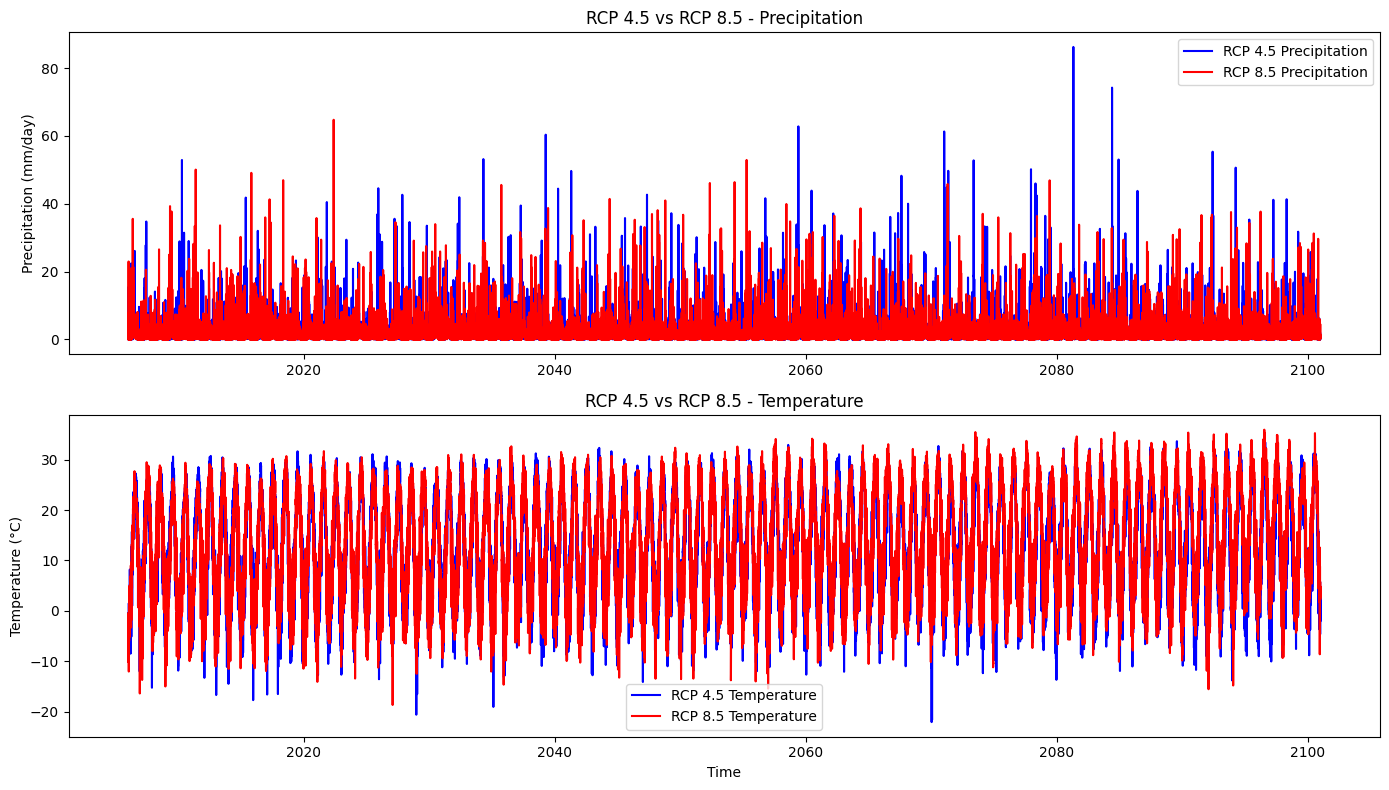

In [7]:
# Function to plot RCP scenarios
def plot_rcp_scenarios(rcp45_prec, rcp85_prec, rcp45_temp, rcp85_temp):
    plt.figure(figsize=(14, 8))

    # Plot Precipitation
    plt.subplot(2, 1, 1)
    plt.plot(rcp45_prec['time'], rcp45_prec['prec'], label='RCP 4.5 Precipitation', color='blue')
    plt.plot(rcp85_prec['time'], rcp85_prec['prec'], label='RCP 8.5 Precipitation', color='red')
    plt.title('RCP 4.5 vs RCP 8.5 - Precipitation')
    plt.ylabel('Precipitation (mm/day)')
    plt.legend()

    # Plot Temperature
    plt.subplot(2, 1, 2)
    plt.plot(rcp45_temp['time'], rcp45_temp['temp'], label='RCP 4.5 Temperature', color='blue')
    plt.plot(rcp85_temp['time'], rcp85_temp['temp'], label='RCP 8.5 Temperature', color='red')
    plt.title('RCP 4.5 vs RCP 8.5 - Temperature')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to visualize
plot_rcp_scenarios(rcp45_prec, rcp85_prec, rcp45_temp, rcp85_temp)